## Imports and Preprocessing

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline
import os
import joblib
from sklearn.preprocessing import LabelEncoder 
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
import warnings
warnings.filterwarnings('ignore')
import librosa
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
import pandas as pd
import librosa
import tensorflow as tf
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm
from keras.models import Sequential, load_model, Model
from keras.layers import Dense,Dropout,Activation,Flatten, Input, Conv1D, MaxPool1D, GlobalAveragePooling1D, BatchNormalization, Reshape, Conv2D, MaxPool2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from scipy.io import wavfile as wav
from keras.metrics import Recall, Precision
from keras.callbacks import ModelCheckpoint, EarlyStopping
import IPython.display as ipd
import librosa 
import librosa.display
from datetime import datetime 
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
filename = 'accentdb_core/data/bangla/speaker_01/bangla_s01_000.wav'

### EDA

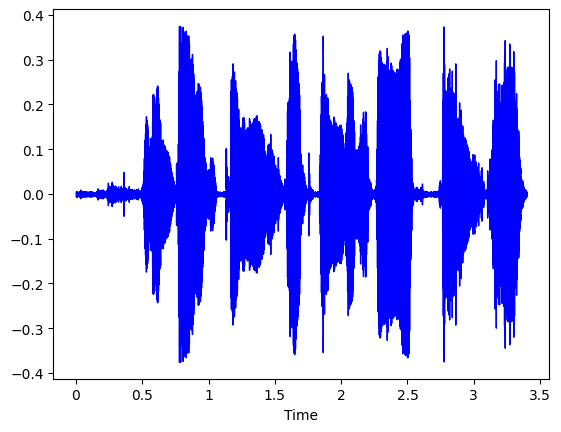

<Figure size 1400x500 with 0 Axes>

In [3]:
#Displaying the wavelenght of the filename american audio
Librosa_data, Librosa_sample_rate = librosa.load(filename)
librosa.display.waveshow(Librosa_data, sr=Librosa_sample_rate,color='blue')
plt.figure(figsize = (14,5))
ipd.Audio(filename)

In [4]:
print('Librosa sample rate = ', Librosa_sample_rate)
print('Mono Audio of Librosa_data:', Librosa_data)

Librosa sample rate =  22050
Mono Audio of Librosa_data: [ 8.9434534e-04  1.0206155e-03  4.1864900e-04 ... -7.9992623e-04
 -2.2558321e-04 -7.4983247e-05]


##### Note: Librosa converts the signal to mono, meaning the channel will alays be 1

In [5]:
### Lets read with scipy
### Scipy help us to see if the audio have noise or 
wave_sample_rate, wave_audio = wav.read(filename)

In [6]:
wave_audio

array([[ 38,  38],
       [ 39,  39],
       [ 40,  40],
       ...,
       [ -9,  -9],
       [  3,   3],
       [-11, -11]], dtype=int16)

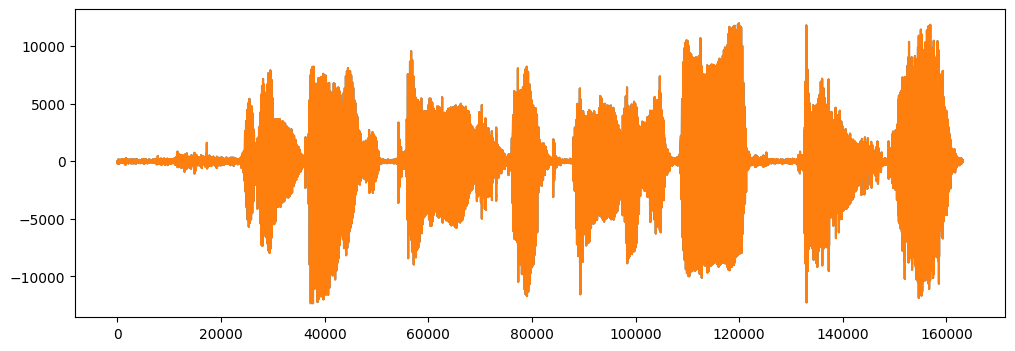

In [7]:
import matplotlib.pyplot as plt

# Original audio
plt.figure(figsize=(12, 4))
plt.plot(wave_audio)

#### Based the original audio signal there's only 1 speaker and no noise.

## Data Extraction

### Extract MFCC

Here we will be using Mel-Frequency Cepstral Coefficients(MFCC) from the audio samples. The MFCC summarises the frequency distribution across the window size, so it is possible to analyse both the frequency and time characteristics of the sound. These audio representations will allow us to identify features for classification.

<img src= "https://image.jimcdn.com/app/cms/image/transf/none/path/sf1ff7ca1dd72191f/image/ib751b6262352cb2a/version/1453992968/image.png" alt ="MFCC" style='width: 1500px;'>

In [8]:
mfccs = librosa.feature.mfcc(y=Librosa_data, sr=Librosa_sample_rate, n_mfcc=26)
print(mfccs.shape)

(26, 147)


In [9]:
type(mfccs)

numpy.ndarray

In [4]:
def mfcc_extractor(file_name, n_mfcc=26):
    audio, sample_rate = librosa.load(file_name) 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
    return mfccs_features

In [35]:
# Filenames
filename1 = r'E:\VSCode\Applied-ML\Project\Audio_classification\UrbanSound8K\dog_bark.wav'
filename2 = r'E:\VSCode\Applied-ML\Project\Audio_classification\UrbanSound8K\ambulance_test.wav'

In [36]:
# Extract MFCCs
mfccs1 = mfcc_extractor(filename1)
mfccs2 = mfcc_extractor(filename2)

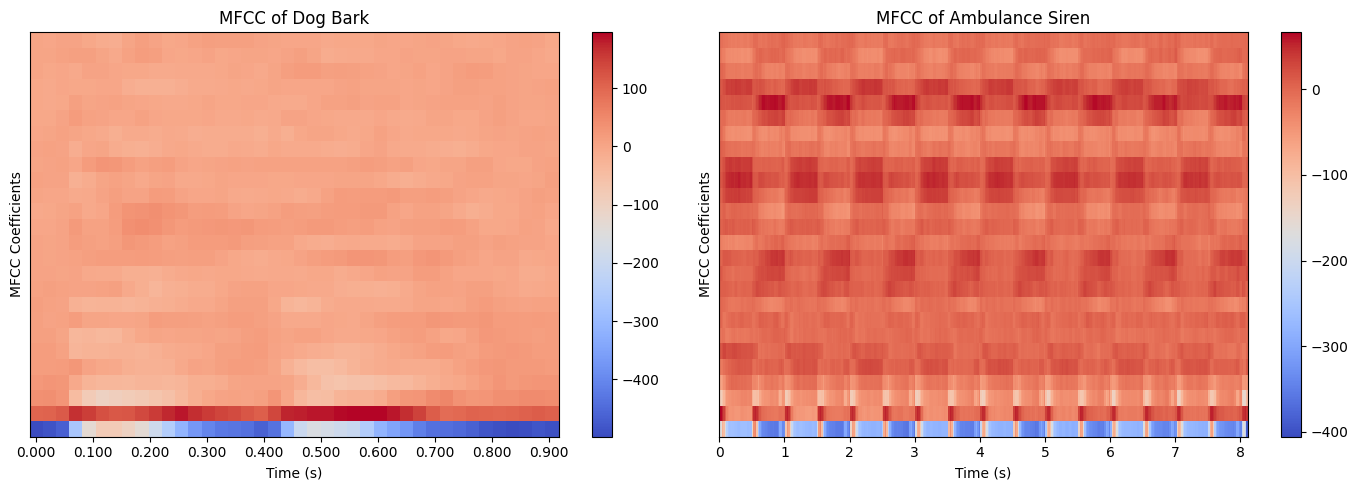

In [37]:
# Plotting side by side
plt.figure(figsize=(14, 5))

# Plot 1
plt.subplot(1, 2, 1)
librosa.display.specshow(mfccs1, x_axis='time')
plt.xlabel('Time (s)')
plt.ylabel('MFCC Coefficients')
plt.title('MFCC of {}'.format('Dog Bark'))
plt.colorbar()

# Plot 2
plt.subplot(1, 2, 2)
librosa.display.specshow(mfccs2, x_axis='time')
plt.xlabel('Time (s)')
plt.ylabel('MFCC Coefficients')
plt.title('MFCC of {}'.format('Ambulance Siren'))
plt.colorbar()

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

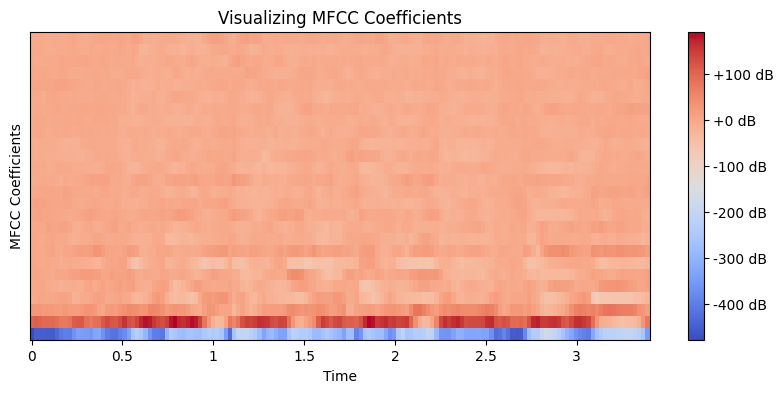

In [12]:
# Displaying the MFCCs
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, sr=Librosa_sample_rate, x_axis='time')

# Labeling the y axis
plt.ylabel('MFCC Coefficients')

# Adding a title
plt.title('Visualizing MFCC Coefficients')

# Adding a colorbar
plt.colorbar(format='%+2.0f dB')

# Show plot
plt.show()

#### Lets extract all MFCCS of audio data in the dataset folder

In [5]:
def feature_extractor():
    DIR = 'accentdb_extended\\data'
    dir_name = os.listdir(DIR)
    speaker_files = []
    #Mapping all the audiofiles at the accentdb_extended folder          
    for folder_name in dir_name:
        if folder_name not in ['british', 'indian']:
            continue
        for speaker in os.listdir(os.path.join(DIR,folder_name)):
            for audio in os.listdir(os.path.join(DIR,folder_name,speaker)):
                filename_speaker = os.path.join(DIR,folder_name,speaker,audio)
                speaker_files.append([folder_name, filename_speaker])
    return speaker_files

In [6]:
f = feature_extractor()
f[0]

['british',
 'accentdb_extended\\data\\british\\speaker_01\\british_s01_001.wav']

In [7]:
audio_data = pd.DataFrame(f, columns = ['Speaker','audio_path'])
print(audio_data.head())
print(audio_data.shape)
print(audio_data['Speaker'].unique())

   Speaker                                         audio_path
0  british  accentdb_extended\data\british\speaker_01\brit...
1  british  accentdb_extended\data\british\speaker_01\brit...
2  british  accentdb_extended\data\british\speaker_01\brit...
3  british  accentdb_extended\data\british\speaker_01\brit...
4  british  accentdb_extended\data\british\speaker_01\brit...
(2968, 2)
['british' 'indian']


In [8]:
n_mfcc=26

In [9]:
def features_extractor(file_name, n_mfcc=n_mfcc):
    audio, sample_rate = librosa.load(file_name) 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
    
    return mfccs_scaled_features

In [10]:
data_extracted = []
file_path = audio_data['audio_path'].tolist()
audio_name = audio_data['Speaker'].tolist()
class_number = audio_data['Speaker'].unique()
i = 0
for i in range(len(audio_data['audio_path'])):
    mfccs = features_extractor(file_path[i])
    data_extracted.append([mfccs,audio_name[i]])
    i+=1

In [11]:
data = pd.DataFrame(data_extracted, columns = ['Features', 'audio_name'])
data.head()

,Features,audio_name
0,"[-338.24332, 59.59438, 4.277312, 32.31301, 2.6...",british
1,"[-424.53555, 61.101173, -0.40874454, 20.746786...",british
2,"[-420.47168, 50.924904, 9.391951, 20.982424, -...",british
3,"[-384.95392, 41.548016, 4.42208, 31.751013, 0....",british
4,"[-420.92984, 53.988293, 5.9720545, 12.186394, ...",british


In [ ]:
X = data['Features'].tolist()
langs = data['audio_name']

In [ ]:
# Fit LabelEncoder to your target labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(langs)
y.shape

(2968,)

In [ ]:
y

array([0, 0, 0, ..., 1, 1, 1])

In [ ]:
np.save('X_mfcc.npy', X)
np.save('y_mfcc.npy', y)

### Extract Spectogram

Data already extracted for the conversion part, we'll just use that

In [27]:
british_spec = joblib.load(r'E:\VSCode\Applied-ML\Project\Accent_Conversion\spectogram\british_spectogram_data.pkl')
indian_spec = joblib.load(r'E:\VSCode\Applied-ML\Project\Accent_Conversion\spectogram\indian_spectogram_data.pkl')

In [30]:
british_spec.shape, indian_spec.shape

((1484, 513, 229), (1484, 513, 229))

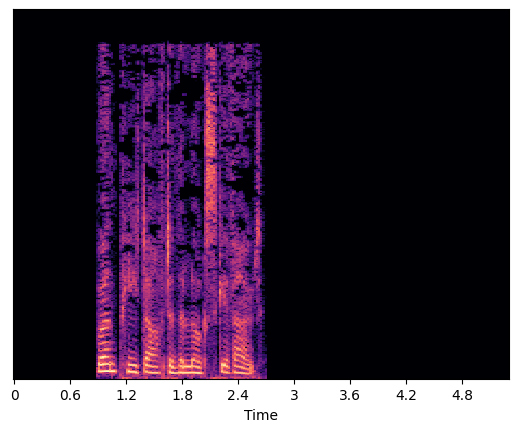

In [33]:
librosa.display.specshow(british_spec[117], x_axis='time')

In [34]:
# Create labels
british_labels = np.zeros(british_spec.shape[0])  # Assign 0 to British
indian_labels = np.ones(indian_spec.shape[0])    # Assign 1 to Indian

In [35]:
# Stack the spectrograms and labels
X = np.vstack((british_spec, indian_spec))
y = np.hstack((british_labels, indian_labels))

In [36]:
# Shuffle the data
random_indices = np.random.permutation(X.shape[0])
X = X[random_indices]
y = y[random_indices]

In [37]:
X.shape, y.shape

((2968, 513, 229), (2968,))

## Training

In [39]:
# # Standardization of x_data (independent variables)
# from sklearn import preprocessing 
# scaler = preprocessing.StandardScaler().fit(X)
# X=scaler.transform(X)
# X[0]

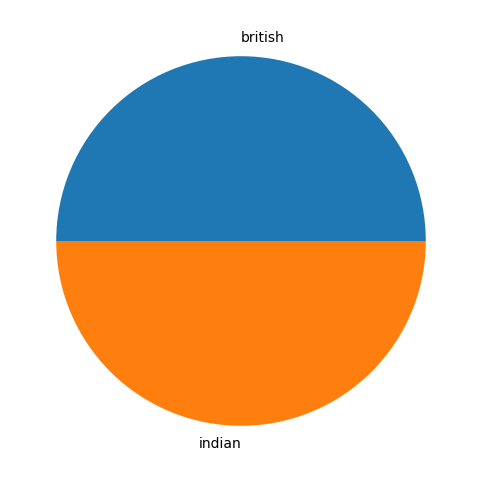

In [40]:
plt.figure(figsize=(12,6))
plt.pie(langs.value_counts(), labels=langs.value_counts().index)
plt.show()

In [41]:
### Train Test Split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.2,random_state=42)

In [42]:
X_train.shape, y_train.shape

((1661, 513, 229), (1661,))

In [43]:
X_test.shape, y_test.shape

((891, 513, 229), (891,))

In [44]:
X_val.shape, y_val.shape

((416, 513, 229), (416,))

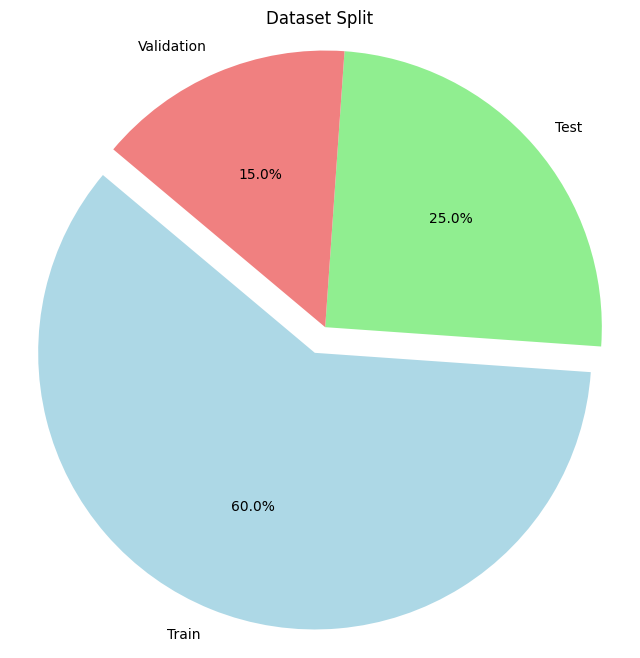

Train Data Shape: (5239, 26)
Test Data Shape: (2183, 26)
Validation Data Shape: (1310, 26)


In [ ]:
# Define data
train_size = len(X_train)
test_size = len(X_test)
val_size = len(X_val)
total_size = train_size + test_size + val_size

# Calculate percentages
train_percent = train_size / total_size * 100
test_percent = test_size / total_size * 100
val_percent = val_size / total_size * 100

# Plot pie chart
labels = ['Train', 'Test', 'Validation']
sizes = [train_percent, test_percent, val_percent]
colors = ['lightblue', 'lightgreen', 'lightcoral']
explode = (0.1, 0, 0)  # explode 1st slice (Train)

plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Dataset Split')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

# Display shapes of datasets
print("Train Data Shape:", X_train.shape)
print("Test Data Shape:", X_test.shape)
print("Validation Data Shape:", X_val.shape)

## Modeling

In [47]:
num_classes = 2
BATCH_SIZE = 32

In [48]:
# Define the number of epochs
n_epochs = 1000

In [49]:
input_shape = (n_mfcc,)  # Define the input shape for the model

In [53]:
inputs = Input(input_shape)
x = Conv1D(1024,3,activation='relu',padding='same')(Reshape((1,n_mfcc))(inputs))
x = BatchNormalization()(x)
x = Dropout(0.35)(x)

x = Conv1D(512,3,activation='relu',padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.35)(x)

x = Conv1D(512,3,activation='relu',padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.35)(x)

x = Conv1D(256,3,activation='relu',padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.35)(x)

x = GlobalAveragePooling1D()(x)

x = Dense(2048, activation='relu')(x)
x = Dropout(0.35)(x)
x = Dense(2048, activation='relu')(x)
x = Dropout(0.35)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.35)(x)

outputs = Dense(1, activation='sigmoid')(x)
model = Model(inputs, outputs)


In [81]:
save_name = f'{n_mfcc}_Conv_4_1024_512_512_256_Dense_3_2048_2048_512_GAP'  # Define the name for saving the model

In [82]:
p = Precision()
r = Recall()

In [83]:
# Compile the model with the specified optimizer, loss function, and metrics
model.compile(optimizer='adam',  # Optimizer
              loss='binary_crossentropy',  # Loss function for binary classification
              metrics=['accuracy', p, r])

In [84]:
model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 26)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 1, 26)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 1, 1024)        │        80,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 1, 1024)        │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 1, 1024)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 1, 512)         │     1,573,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 1, 512)         │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 1, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 1, 512)         │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 1, 512)         │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 1, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 1, 256)         │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 1, 256)         │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 1, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2048)           │       526,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 2048)           │     4,196,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 8,616,193 (32.87 MB)

 Trainable params: 8,611,585 (32.85 MB)

 Non-trainable params: 4,608 (18.00 KB)

In [85]:
# Define ModelCheckpoint callback to save the best weights during training

tl_checkpoint_1 = ModelCheckpoint(
    filepath=f'models/{save_name}.weights.best.keras',
    save_best_only=True,  # Save only the best model weights
    verbose=1
)

In [86]:
# Define EarlyStopping callback to stop training when validation loss stops improving

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,  # Restore best model weights upon early stopping
    mode='min'
)

In [ ]:
history = model.fit(X_train, y_train,
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            validation_data=[X_val, y_val],
                            callbacks=[tl_checkpoint_1, early_stop],
                            verbose=1)

Epoch 1/1000
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.2562 - loss: 2.1778 - precision: 0.4028 - recall: 0.0748
Epoch 1: val_loss improved from inf to 1.69756, saving model to models/13_Conv_4_1024_512_512_256_Dense_3_2048_2048_512.weights.best.keras
164/164 ━━━━━━━━━━━━━━━━━━━━ 19s 81ms/step - accuracy: 0.2567 - loss: 2.1764 - precision: 0.4035 - recall: 0.0751 - val_accuracy: 0.4458 - val_loss: 1.6976 - val_precision: 0.6557 - val_recall: 0.2282
Epoch 2/1000
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.4354 - loss: 1.6641 - precision: 0.6220 - recall: 0.2290
Epoch 2: val_loss improved from 1.69756 to 1.49198, saving model to models/13_Conv_4_1024_512_512_256_Dense_3_2048_2048_512.weights.best.keras
164/164 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.4355 - loss: 1.6642 - precision: 0.6221 - recall: 0.2290 - val_accuracy: 0.4969 - val_loss: 1.4920 - val_precision: 0.6781 - val_recall: 0.3008
Epoch 3/1000
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accurac

In [88]:
prec_key = [key for key in history.history.keys() if key[0]=='p'][0]
rec_key = [key for key in history.history.keys() if key[0]=='r'][0]

In [89]:
prec_key, rec_key

('precision_1', 'recall_1')

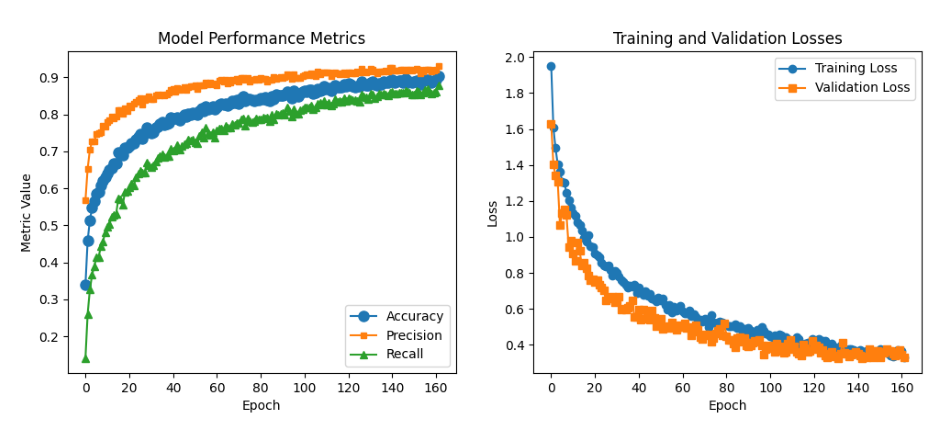

In [13]:
# Plotting with markers
plt.figure(figsize=(12, 10))

# First plot: Model performance metrics
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy', marker='o', markersize=8)
plt.plot(history.history[prec_key], label='Precision', marker='s', markersize=5)
plt.plot(history.history[rec_key], label='Recall', marker='^')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Model Performance Metrics')
plt.legend()

# Second plot: Training and validation losses
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()

# Save and show the plot
plt.savefig(f'graphs/{save_name}.png')
plt.show()

## MFCC Model Evaluation

In [ ]:
# Generate predictions
model = load_model(f'models/{save_name}.weights.best.keras')
# Predict on the test data
y_pred_prob = model.predict(X_test, verbose=0)
threshold = 0.5  # You can adjust this threshold as needed
# Assuming y_pred_prob is your predicted probabilities
y_pred = (y_pred_prob > threshold).astype(int)

In [ ]:
# Evaluate the model
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test, y_test, verbose=0)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)

Test Loss: 0.06681027263402939
Test Accuracy: 0.8797979593276978
Test Precision: 0.9068518805503845
Test Recall: 0.8613953638076782


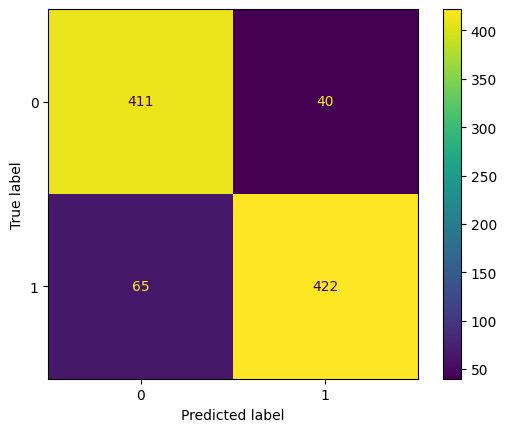

In [ ]:
# Generate classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Generate confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(conf_mat)
disp.plot()
plt.show()


## Classification via Spectogram

In [58]:
input_shape = X[0].shape

In [67]:
inputs = Input(input_shape)
x = Conv2D(1024,3,activation='relu',padding='same')(Reshape((1,input_shape[0], input_shape[1]))(inputs))
x = MaxPool2D((2,2), padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.35)(x)

x = Conv2D(512,3,activation='relu',padding='same')(x)
x = MaxPool2D((2,2), padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.35)(x)

x = Conv2D(512,3,activation='relu',padding='same')(x)
x = MaxPool2D((2,2), padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.35)(x)

x = Conv2D(256,3,activation='relu',padding='same')(x)
x = MaxPool2D((2,2), padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.35)(x)

x = GlobalAveragePooling2D()(x)

x = Dense(2048, activation='relu')(x)
x = Dropout(0.35)(x)
x = Dense(2048, activation='relu')(x)
x = Dropout(0.35)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.35)(x)

outputs = Dense(1, activation='sigmoid')(x)
model = Model(inputs, outputs)


In [60]:
save_name = f'spec_Conv_4_1024_512_512_256_Dense_3_2048_2048_512_GAP'  # Define the name for saving the model

In [68]:
p = Precision()
r = Recall()

In [69]:
# Compile the model with the specified optimizer, loss function, and metrics
model.compile(optimizer='adam',  # Optimizer
              loss='binary_crossentropy',  # Loss function for binary classification
              metrics=['accuracy', p, r])

In [70]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 513, 229)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 1, 513, 229)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 1, 513, 1024)   │     2,111,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 1, 257, 1024)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 1, 257, 1024)   │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 1, 257, 1024)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 1, 257, 512)    │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 1, 129, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 1, 129, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 1, 129, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 1, 129, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 1, 65, 512)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 1, 65, 512)     │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 1, 65, 512)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 1, 65, 256)     │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 1, 33, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 1, 33, 256)     │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 1, 33, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 2048)           │       526,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2048)           │     4,196,352 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 16,151,809 (61.61 MB)

 Trainable params: 16,147,201 (61.60 MB)

 Non-trainable params: 4,608 (18.00 KB)

In [71]:
# Define ModelCheckpoint callback to save the best weights during training

tl_checkpoint_1 = ModelCheckpoint(
    filepath=f'models/{save_name}.weights.best.keras',
    save_best_only=True,  # Save only the best model weights
    verbose=1
)

In [72]:
# Define EarlyStopping callback to stop training when validation loss stops improving

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True,  # Restore best model weights upon early stopping
    mode='min'
)

In [73]:
history = model.fit(X_train, y_train,
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            validation_data=[X_val, y_val],
                            callbacks=[tl_checkpoint_1, early_stop],
                            verbose=1)

Epoch 1/1000
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 833ms/step - accuracy: 0.6253 - loss: 0.6745 - precision_1: 0.6521 - recall_1: 0.6562
Epoch 1: val_loss improved from inf to 334.63336, saving model to models/spec_Conv_4_1024_512_512_256_Dense_3_2048_2048_512_GAP.weights.best.keras
52/52 ━━━━━━━━━━━━━━━━━━━━ 53s 913ms/step - accuracy: 0.6267 - loss: 0.6733 - precision_1: 0.6531 - recall_1: 0.6575 - val_accuracy: 0.4688 - val_loss: 334.6334 - val_precision_1: 0.4688 - val_recall_1: 1.0000
Epoch 2/1000
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 818ms/step - accuracy: 0.7426 - loss: 0.5768 - precision_1: 0.7807 - recall_1: 0.7269
Epoch 2: val_loss improved from 334.63336 to 3.41901, saving model to models/spec_Conv_4_1024_512_512_256_Dense_3_2048_2048_512_GAP.weights.best.keras
52/52 ━━━━━━━━━━━━━━━━━━━━ 45s 873ms/step - accuracy: 0.7428 - loss: 0.5760 - precision_1: 0.7808 - recall_1: 0.7269 - val_accuracy: 0.6034 - val_loss: 3.4190 - val_precision_1: 0.5452 - val_recall_1: 0.9282
Epoch 3/1000
52/52 ━━━━━━━

In [74]:
prec_key = [key for key in history.history.keys() if key[0]=='p'][0]
rec_key = [key for key in history.history.keys() if key[0]=='r'][0]

In [75]:
prec_key, rec_key

('precision_1', 'recall_1')

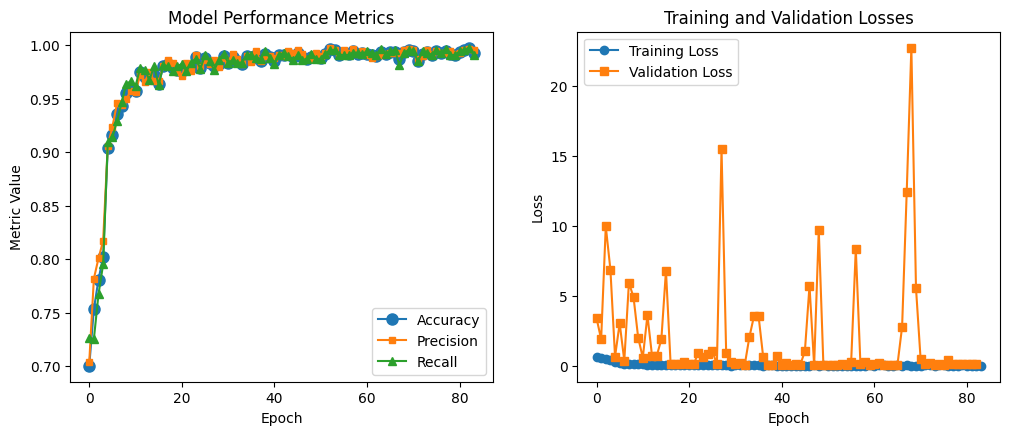

In [80]:
# Plotting with markers
plt.figure(figsize=(12, 10))

# First plot: Model performance metrics
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy', marker='o', markersize=8)
plt.plot(history.history[prec_key], label='Precision', marker='s', markersize=5)
plt.plot(history.history[rec_key], label='Recall', marker='^')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Model Performance Metrics')
plt.legend()

# Second plot: Training and validation losses
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'][1:], label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()

# Save and show the plot
plt.savefig(f'graphs/{save_name}.png')
plt.show()

## Spetogram Model Evaluation

In [ ]:
# Generate predictions
model = load_model(f'models/{save_name}.weights.best.keras')
# Predict on the test data
y_pred_prob = model.predict(X_test, verbose=0)
threshold = 0.5  # You can adjust this threshold as needed
# Assuming y_pred_prob is your predicted probabilities
y_pred = (y_pred_prob > threshold).astype(int)

In [5]:
# Evaluate the model
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test, y_test, verbose=0)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)

Test Loss: 0.06681027263402939
Test Accuracy: 0.9797979593276978
Test Precision: 0.9768518805503845
Test Recall: 0.9813953638076782


Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98       461
         1.0       0.98      0.98      0.98       430

    accuracy                           0.98       891
   macro avg       0.98      0.98      0.98       891
weighted avg       0.98      0.98      0.98       891



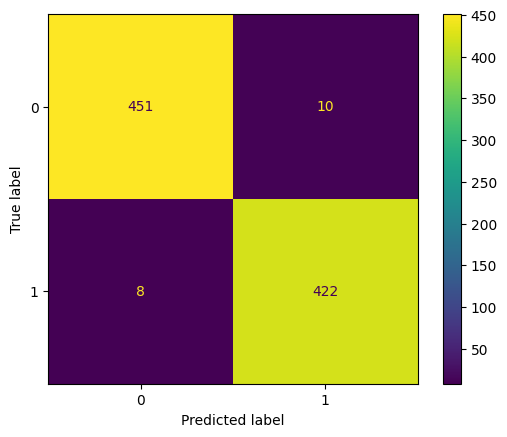

In [ ]:
# Generate classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Generate confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(conf_mat)
disp.plot()
plt.show()
